In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet

In [2]:
df1 = pd.read_csv("data/야수_전처리_ver12.csv")
df2 = pd.read_csv("data/2026_FA예정_타자.csv")

In [3]:
# 계약금 컬럼 생성
df1['FA 계약 총액'] = df1['FA 계약 총액'].fillna(0)
df1['연봉'] = df1['연봉'].fillna(0)
df1['계약금'] = df1['FA 계약 총액'] + df1['연봉']

In [4]:
# 전처리 함수
def preprocess(df):
    df = df.copy()
    if '구분' in df.columns:
        df = df[~df['구분'].isin(['해외', 'FA 1년차'])]
    if 'FA등급' in df.columns:
        df = df[~df['FA등급'].isin(['해외', 'FA 1년차'])]
    if '플레이년도' in df.columns:
        df = df[df['플레이년도'] > 2015]

    drop_cols = ['선수명_수정', 'FA 계약 총액', '연봉', '잔류여부']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
    df = df.groupby('선수명', as_index=False).mean(numeric_only=True)
    return df

# 전처리 적용
df1_cleaned = preprocess(df1)
df2_cleaned = preprocess(df2)

C:\Users\Lee\AppData\Local\Temp\ipykernel_24520\554469304.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')


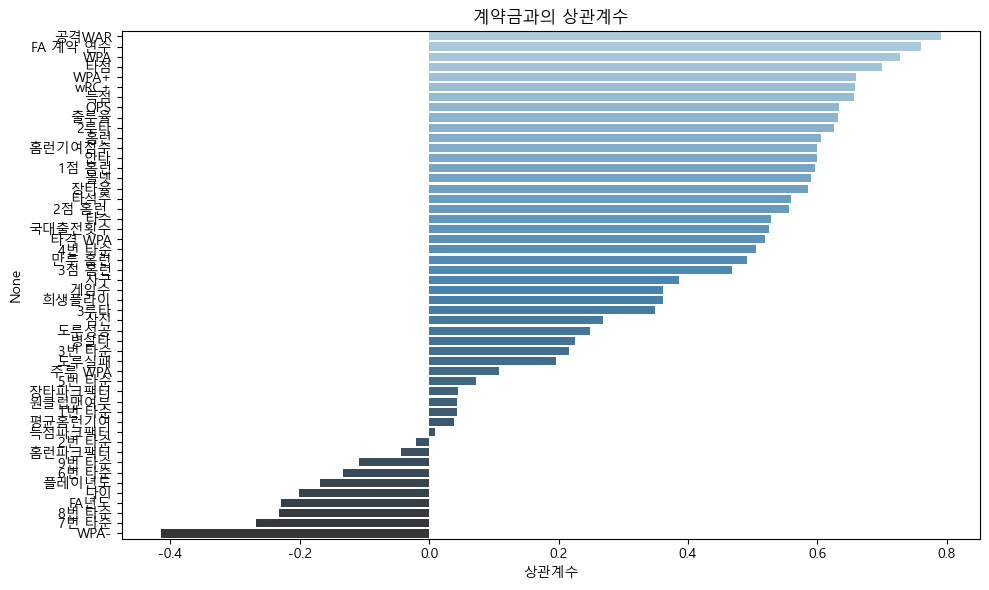

In [5]:
# 상관계수 계산 및 가중치
correlations = df1_cleaned.corr(numeric_only=True)['계약금'].drop('계약금').sort_values(ascending=False)
weights = correlations.abs() / correlations.abs().sum()
weight_df = pd.DataFrame({'컬럼명': weights.index, '가중치': weights.values})

# 한글 시각화 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 시각화: 상관계수
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')
plt.title('계약금과의 상관계수')
plt.xlabel('상관계수')
plt.tight_layout()
plt.show()

In [6]:
# 공통 피처 추출
predict_features = [f for f in weights.index if f in df1_cleaned.columns and f in df2_cleaned.columns]
print(f"예측에 사용될 공통 피처: {predict_features}")

# 데이터 준비
X = df1_cleaned[predict_features]
y = df1_cleaned['계약금']
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy[predict_features]
y = Xy['계약금']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(df2_cleaned[predict_features])

예측에 사용될 공통 피처: ['공격WAR', 'WPA', '타점', 'WPA+', 'wRC+', '득점', 'OPS', '출루율', '2루타', '홈런', '홈런기여점수', '안타', '1점 홈런', '볼넷', '장타율', '타석수', '타수', '국대출전횟수', '타격 WPA', '4번 타순', '만루 홈런', '3점 홈런', '사구', '게임수', '희생플라이', '3루타', '삼진', '도루성공', '병살타', '3번 타순', '도루실패', '주루 WPA', '5번 타순', '장타파크팩터', '원클럽맨여부', '1번 타순', '득점파크팩터', '2번 타순', '홈런파크팩터', '9번 타순', '6번 타순', '플레이년도', '나이', 'FA년도', '8번 타순', '7번 타순', 'WPA-']


In [7]:
# ElasticNet 모델 학습 
model = ElasticNet(random_state=42)
model.fit(X_train_scaled, y_train)

ElasticNet(random_state=42)

In [8]:
# 검증 성능 확인
val_pred = model.predict(X_val_scaled)
rmse = mean_squared_error(y_val, val_pred, squared=False)
print(f"[ElasticNet] 검증 RMSE: {rmse:,.2f}")

# 예측 결과 저장
df2_cleaned['계약금'] = model.predict(X_test_scaled)

[ElasticNet] 검증 RMSE: 140,141.35


C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


피처 계수 (ElasticNet):
       컬럼명  계수 (ElasticNet)  상관계수 기반 가중치
17  국대출전횟수     31710.890398     0.027093
0    공격WAR     23724.877668     0.040855
42      나이    -19528.723455     0.010384
26      삼진    -18884.805962     0.013870
27    도루성공     17384.182456     0.012825
1      WPA     16788.497410     0.037568
39   9번 타순     16174.406232     0.005563
30    도루실패     15770.627595     0.010136
22      사구     14781.564782     0.019909
37   2번 타순    -14605.627350     0.001028
25     3루타     13567.189843     0.018032
2       타점     12165.564913     0.036160
12   1점 홈런     11960.636388     0.030799
31  주루 WPA     11433.302843     0.005569
41   플레이년도     11095.858215     0.008669
3     WPA+     10016.191539     0.034056
44   8번 타순      8097.842906     0.011944
18  타격 WPA      7935.299664     0.026799
4     wRC+      7912.714471     0.033973
35   1번 타순     -7693.686366     0.002211
40   6번 타순     -7361.847852     0.006862
5       득점      7279.776058     0.033944
9       홈런      7131.430480     0.031

C:\Users\Lee\AppData\Local\Temp\ipykernel_24520\1553342695.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='계수 (ElasticNet)', y='컬럼명', palette='YlOrBr')


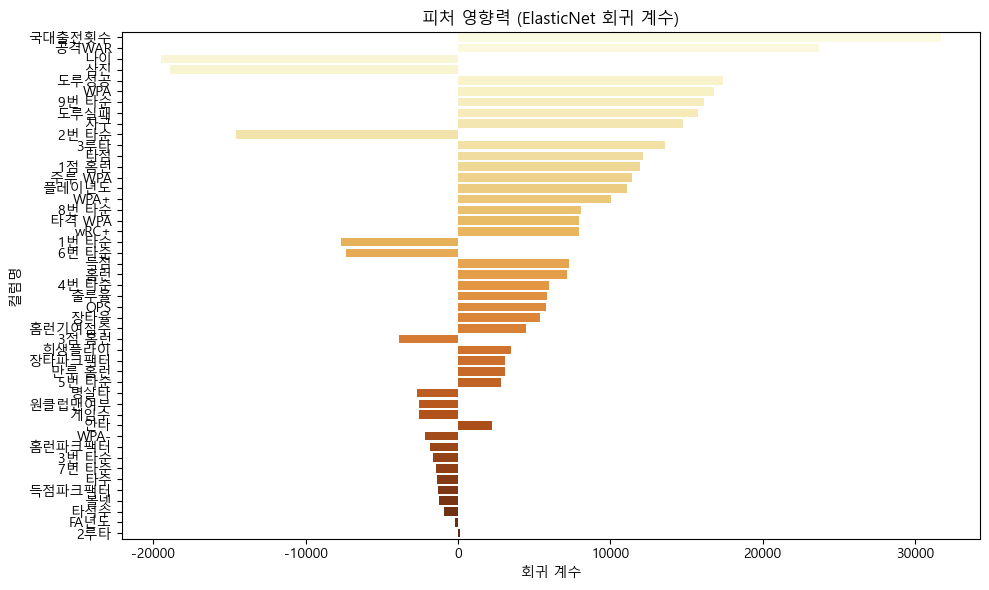

In [9]:
# 피처 중요도 (= 회귀 계수)
importance_df = pd.DataFrame({
    '컬럼명': predict_features,
    '계수 (ElasticNet)': model.coef_,
    '상관계수 기반 가중치': [weights[f] for f in predict_features]
}).sort_values(by='계수 (ElasticNet)', key=lambda x: abs(x), ascending=False)

print("피처 계수 (ElasticNet):")
print(importance_df)

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='계수 (ElasticNet)', y='컬럼명', palette='YlOrBr')
plt.title('피처 영향력 (ElasticNet 회귀 계수)')
plt.xlabel('회귀 계수')
plt.tight_layout()
plt.show()

In [10]:
# 예측 결과 출력
print("예측 계약금 상위 선수 (ElasticNet):")
print(df2_cleaned[['선수명', '계약금']].sort_values(by='계약금', ascending=False))

예측 계약금 상위 선수 (ElasticNet):
    선수명            계약금
6   박해민  315916.305528
5   박찬호  268692.709550
12  최원준  262024.761225
0   강민호  255725.497987
3   박병호  236017.896617
13  최형우  232671.920589
1   강백호  186465.208007
7   손아섭  168714.306522
2   김재환  153785.535220
9   장성우  139833.390558
11  조수행  139653.010864
14  황재균  101243.255401
4   박승욱   73130.708097
10   정훈   -5485.569140
8   이재원  -43708.305904
